In [1]:
%reload_ext autoreload

In [2]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np
import random
import csv
import pandas as pd

from fastai.imports import *
from fastai.structured import *
from matplotlib import pyplot
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.metrics import f1_score,\
    accuracy_score, confusion_matrix,\
    precision_score, recall_score,\
    roc_curve, roc_auc_score,\
    cohen_kappa_score, mean_absolute_error,\
    precision_recall_curve, auc,\
    average_precision_score

set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/justinhennessy/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
import csv

sys.path.append('../lib')
import utils
import preprocessing

In [4]:
# Load in data

PATH = "../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

In [5]:
print(len(df_raw.loc[df_raw.churned == 0]), df_raw.loc[df_raw.churned == 0].shape)

df_processed = preprocessing.prepare_data(df_raw.loc[df_raw.licence_status != "STAGING"])
print(len(df_processed), df_processed.shape)

df_filtered = df_processed.loc[df_processed.churned == 0]
df_data, y_data, nas = proc_df(df_filtered, 'churned')
print(len(df_data), df_data.shape)

2780 (2780, 38)
Sorting dataframe by licence_registration_date ...
Converting annual_revenue to a number ...
Defaulting all NaN values with median ...
Defaulting annual_revenue for missing values to the plans mean or platform medeian ...
Binning last_login_days
Binning NPS data
Fixing days_active abnormal values ...


../lib/preprocessing.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature][i] = random_replace_value(df, feature)


One-hot encoding customer_account_status
One-hot encoding plan
One-hot encoding nps
Preprocessing dates ...
Dropping features ...
Replacing NaN values with median and adding '_was_nan' column ...
Convert categorical features into numbers ...
List any features that still have NaN values ...
Feature has NaN values: last_login_categories
5547 (5547, 141)
2438 (2438, 140)


/Users/justinhennessy/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
joblib_file = "churn_model.pkl"

# Load from file
churn_model = joblib.load(joblib_file)

In [7]:
predictions = churn_model.predict(df_data)
probability = churn_model.predict_proba(df_data)[:,1]
len(probability), len(predictions), len(df_filtered)

(2438, 2438, 2438)

In [8]:
df_predictions = pd.DataFrame(predictions)
df_probability = pd.DataFrame(probability)

In [9]:
df_output = df_processed[df_processed.churned == 0].copy()

In [10]:
df_output['prediction'] = predictions
df_output['probability'] = probability

In [11]:
# Calculate churn concern %
churn_concern_count = len(df_output.loc[df_output['prediction'] == 1])
total_active = len(df_output)
churn_concern_percent = round((churn_concern_count / total_active) * 100, 2)
print(f"Churn concern count: {churn_concern_count} of {total_active} ({churn_concern_percent}%)")

Churn concern count: 23 of 2438 (0.94%)


In [12]:
# Sort churn concerns by probability
df_sorted = df_output.loc[df_output['prediction'] == 1].sort_values(by=['probability'], ascending=False)

In [13]:
#df_output.annual_revenue_log.var(), df_output.annual_revenue_log.skew(), df_output.annual_revenue_log.mad(), df_output.annual_revenue_log.mode()



In [14]:
now = datetime.datetime.now()

#for i in range(len(df_sorted.loc[df_sorted['probability'] > 0.551])):
for i in range(len(df_sorted)):
    print(f"{now},{df_sorted.username.iloc[i]},{df_raw[df_raw.username == df_sorted.username.iloc[i]].url.iloc[0]},{df_sorted.annual_revenue.iloc[i]},{df_sorted.probability.iloc[i]}")
          
    #with open('../data/predictions.csv', 'w') as writeFile:
    #    writer = csv.writer(writeFile)
    #    writer.writerows(sorted_array)

#writeFile.close()

2019-10-21 05:05:28.403221,N059446,tobias-tattoo-a.neto.com.au,0.0,0.6837026421039055
2019-10-21 05:05:28.403221,N061491,marshall.neto.com.au,0.0,0.6816497517716482
2019-10-21 05:05:28.403221,N040687,vantage-demo.neto.com.au,45800.31,0.6765145033028689
2019-10-21 05:05:28.403221,N063144,www.sydneysupplies.com.au,1843.2,0.5943896544249997
2019-10-21 05:05:28.403221,N061402,zoomautoparts.neto.com.au,0.0,0.5843166321698735
2019-10-21 05:05:28.403221,N064484,www.hbvapour.nz,16244.03,0.5745920023961006
2019-10-21 05:05:28.403221,N061994,invidia-exhausts.com.au,70029.68,0.5551711015435938
2019-10-21 05:05:28.403221,N060361,the-drawing-roo.neto.com.au,13949.17,0.5517054554808699
2019-10-21 05:05:28.403221,N062334,www.uniquepartyshop.com.au,4451.42,0.5455811011652214
2019-10-21 05:05:28.403221,N064573,www.eliquidaustralia.co,34199.1,0.5420877062333141
2019-10-21 05:05:28.403221,N062601,dollardropship.neto.com.au,98238.14,0.5205642863124287
2019-10-21 05:05:28.403221,N064149,force-industrie.net

In [22]:
from eli5 import show_prediction
show_prediction(churn_model, df_data.iloc[6], feature_names=list(df_data.columns), show_feature_values=True)

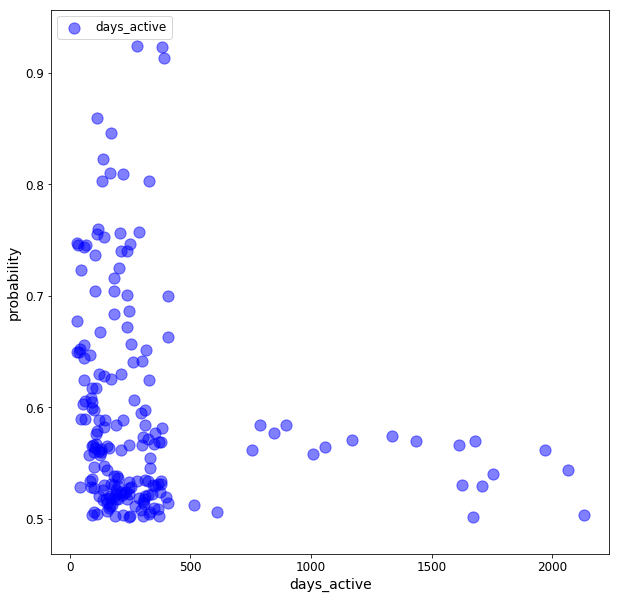

In [177]:
import matplotlib.pyplot as plt

feature='days_active'

plt.figure(figsize=(10,10))
plt.scatter(df_sorted[feature], df_sorted['probability'],
            c='b', marker='.', label=feature,
            s=500, alpha=.5)

plt.legend(loc='upper left')
plt.xlabel(feature)
plt.ylabel("probability")

plt.show()

In [168]:
print(df_sorted[feature].mode())

0    4.060443
1    4.521789
2    4.804021
3    5.252273
4    5.356586
5    5.509388
dtype: float64


In [134]:
def general_stats(df, feature):
    array = utils.data_summary_feature(df, feature)
    print(array[0])
    print("")
    count = 1
    for heading in ['Min', 'Max', 'Mean', 'Trimmed Mean', 'Median', 'Mode', 'Std', 'CV']:
        print(f"{heading}: {array[count]}")
        count += 1
        
general_stats(df_sorted,feature)

cases_age_hours_total_log

Min: 0.0
Max: 8.341171747170762
Mean: 6.179131782952844
Trimmed Mean: 6.411541112686469
Median: 6.905640312197924
Mode: 0    7.055313
dtype: float64
Std: 1.5496762518323817
CV: 0.2507919083563925
